In [1]:
##Keras Imports
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers.core import Lambda,Dense,Dropout
from keras.layers import Input,Flatten
from keras.layers.convolutional import Convolution2D,ZeroPadding2D,MaxPooling2D
from keras.optimizers import SGD,RMSprop
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import image

from scipy import ndimage
from PIL import Image
import matplotlib.image as mpimg

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as mplot
import glob,os

In [3]:
def create_directory_structure(competition_name):
    HOME_DIR = os.getcwd()
    TRAIN_PATH = os.path.join(os.path.join(HOME_DIR,'data'),'%s/train'%competition_name)
    TEST_PATH = os.path.join(os.path.join(HOME_DIR,'data'),'%s/test'%competition_name)
    VALID_PATH = os.path.join(os.path.join(HOME_DIR,'data'),'%s/valid'%competition_name)
    TEST_UNKNOWN_PATH = os.path.join(TEST_PATH,'unknown')
    return HOME_DIR,TRAIN_PATH,TEST_PATH,VALID_PATH,TEST_UNKNOWN_PATH
HOME_DIR,TRAIN_PATH,TEST_PATH,VALID_PATH,TEST_UNKNOWN_PATH = create_directory_structure('plants')

In [4]:
if not os.path.exists(VALID_PATH): os.mkdir(VALID_PATH)
if not os.path.exists(TEST_UNKNOWN_PATH):os.mkdir(TEST_UNKNOWN_PATH)
if not os.path.exists(VALID_PATH): os.mkdir(VALID_PATH)

test_file_names = list(os.walk(TEST_PATH))[0][2]
for file_name in test_file_names:
    os.renames(os.path.join(TEST_PATH,file_name),os.path.join(TEST_UNKNOWN_PATH,file_name))

In [54]:
## Logic to modify file names according to directory names.
for sub_dir in os.listdir(TRAIN_PATH):
    full_path = os.path.join(TRAIN_PATH,sub_dir)
    all_files = os.walk(full_path)
    all_files = list(all_files)[0][2]
    #print all_files
    for i,file_name in enumerate(all_files):
        dir_path=os.path.join(TRAIN_PATH,sub_dir,file_name)
        dir_path_modified = os.path.join(TRAIN_PATH,sub_dir,sub_dir+'.'+str(i)+'.png')
        #print dir_path
        #print dir_path_modified
        os.rename(dir_path,dir_path_modified)

In [8]:
## Logic to move 10% of images from train sub dirs to Validation sub dirs.
for sub_dir in os.listdir(TRAIN_PATH):
    full_path = os.path.join(TRAIN_PATH,sub_dir)
    all_files = list(os.walk(full_path))[0][2]
    #print sub_dir, len(all_files)
    all_files = np.random.permutation(all_files)
    for i in range(int(len(all_files)*0.10)): os.renames(os.path.join(TRAIN_PATH,sub_dir,all_files[i]),os.path.join(VALID_PATH,sub_dir,all_files[i]))
    

In [5]:
## Logic to print current count of images in training sub dirs
for sub_dir in os.listdir(TRAIN_PATH):
    print sub_dir, len(list(os.walk(os.path.join(TRAIN_PATH,sub_dir)))[0][2])

Sugar beet 313
Shepherds Purse 188
Loose Silky-bent 531
Small-flowered Cranesbill 403
Scentless Mayweed 419
Fat Hen 386
Charlock 316
Maize 180
Black-grass 214
Common wheat 180
Common Chickweed 495
Cleavers 234


In [6]:
## Logic to print current count of images in validation sub dirs
for sub_dir in os.listdir(VALID_PATH):
    print sub_dir, len(list(os.walk(os.path.join(VALID_PATH,sub_dir)))[0][2])

Sugar beet 72
Shepherds Purse 43
Loose Silky-bent 123
Small-flowered Cranesbill 93
Scentless Mayweed 97
Fat Hen 89
Charlock 74
Maize 41
Black-grass 49
Common wheat 41
Common Chickweed 116
Cleavers 53


In [25]:
batch_size=64
no_of_epochs = 10
generator = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
       height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
       channel_shift_range=10., horizontal_flip=True)
train_batches = generator.flow_from_directory(directory = TRAIN_PATH,batch_size = batch_size,target_size=(224,224))
val_batches = generator.flow_from_directory(directory = VALID_PATH,batch_size = batch_size,target_size=(224,224))

Found 3859 images belonging to 12 classes.
Found 891 images belonging to 12 classes.


In [26]:
from vgg16bn import Vgg16BN

In [27]:
vgg = Vgg16BN()
vgg.finetune(train_batches)
vgg.model.optimizer.lr = 0.01

In [28]:
vgg.model.fit_generator(generator=train_batches,samples_per_epoch=train_batches.nb_sample,nb_epoch=4,
                        validation_data=val_batches, nb_val_samples = val_batches.nb_sample)

Epoch 1/4
3859/3859 [==============================] - 214s - loss: 7.8748 - acc: 0.3993 - val_loss: 8.7008 - val_acc: 0.3692
Epoch 2/4
3859/3859 [==============================] - 214s - loss: 7.2627 - acc: 0.4882 - val_loss: 7.1327 - val_acc: 0.4804
Epoch 3/4
3859/3859 [==============================] - 214s - loss: 6.9957 - acc: 0.5092 - val_loss: 5.3068 - val_acc: 0.6128
Epoch 4/4
3859/3859 [==============================] - 214s - loss: 6.6174 - acc: 0.5442 - val_loss: 5.4805 - val_acc: 0.6038


In [31]:
layers = vgg.model.layers
dense_start = [idx for idx,layer in enumerate(layers) if type(layer) is Flatten][0]
for layer in layers[dense_start+1:]:
    layer.trainable = True
vgg.model.compile(optimizer=SGD(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

vgg.model.fit_generator(generator=train_batches,samples_per_epoch=train_batches.nb_sample,nb_epoch=4,
                        validation_data=val_batches, nb_val_samples = val_batches.nb_sample)

Epoch 1/4
3859/3859 [==============================] - 193s - loss: 6.4266 - acc: 0.5545 - val_loss: 6.2141 - val_acc: 0.5612
Epoch 2/4
3859/3859 [==============================] - 123s - loss: 6.1407 - acc: 0.5776 - val_loss: 5.7826 - val_acc: 0.5937
Epoch 3/4
3859/3859 [==============================] - 180s - loss: 5.8503 - acc: 0.5973 - val_loss: 5.4964 - val_acc: 0.6117
Epoch 4/4
3859/3859 [==============================] - 214s - loss: 5.5156 - acc: 0.6214 - val_loss: 5.4046 - val_acc: 0.6285


In [35]:
for layer in layers[12:]:
    layer.trainable = True
vgg.model.compile(optimizer=SGD(lr=0.00001),loss='categorical_crossentropy',metrics=['accuracy'])
vgg.model.fit_generator(generator=train_batches,samples_per_epoch=train_batches.nb_sample,nb_epoch=5,
                        validation_data=val_batches, nb_val_samples = val_batches.nb_sample)

Epoch 1/5
3859/3859 [==============================] - 430s - loss: 4.9848 - acc: 0.6561 - val_loss: 4.4498 - val_acc: 0.6880
Epoch 2/5
3859/3859 [==============================] - 426s - loss: 4.6753 - acc: 0.6815 - val_loss: 4.2165 - val_acc: 0.7127
Epoch 3/5
3859/3859 [==============================] - 429s - loss: 4.3517 - acc: 0.7046 - val_loss: 4.0865 - val_acc: 0.7228
Epoch 4/5
3859/3859 [==============================] - 413s - loss: 4.4950 - acc: 0.6940 - val_loss: 4.7609 - val_acc: 0.6813
Epoch 5/5
3859/3859 [==============================] - 243s - loss: 4.2172 - acc: 0.7087 - val_loss: 3.6069 - val_acc: 0.7475


In [36]:
vgg.model.optimizer.lr = 0.00001
vgg.model.fit_generator(generator=train_batches,samples_per_epoch=train_batches.nb_sample,nb_epoch=5,
                        validation_data=val_batches, nb_val_samples = val_batches.nb_sample)

Epoch 1/5
3859/3859 [==============================] - 233s - loss: 4.0137 - acc: 0.7251 - val_loss: 3.9880 - val_acc: 0.7273
Epoch 2/5
2195/3859 [================>.............] - ETA: 89s - loss: 4.0146 - acc: 0.7207

KeyboardInterrupt: 

In [41]:
test_batches = generator.flow_from_directory(path = TEST_PATH,target_size=(224,224),batch_size = batch_size)
predictions = vgg.model.predict_generator(test_batches,test_batches.nb_sample)

Found 794 images belonging to 1 classes.


In [52]:
filenames = [filename.split('/')[-1] for filename in test_batches.filenames]
classes = [vgg.classes[np.argmax(pred)] for pred in predictions]

In [53]:
filenames[:5]

['116b136de.png',
 '6908fb540.png',
 'e4a76885b.png',
 '44e8b8833.png',
 'acdb75e00.png']

In [56]:
from collections import Counter
Counter(classes)

Counter({'Black-grass': 32,
         'Charlock': 84,
         'Cleavers': 76,
         'Common Chickweed': 110,
         'Common wheat': 29,
         'Fat Hen': 53,
         'Loose Silky-bent': 129,
         'Maize': 29,
         'Scentless Mayweed': 71,
         'Shepherds Purse': 14,
         'Small-flowered Cranesbill': 84,
         'Sugar beet': 83})

In [59]:
submission  = np.stack([filenames,classes])

In [60]:
submission[:5]

array([['116b136de.png', 'Fat Hen'],
       ['6908fb540.png', 'Loose Silky-bent'],
       ['e4a76885b.png', 'Common Chickweed'],
       ['44e8b8833.png', 'Shepherds Purse'],
       ['acdb75e00.png', 'Fat Hen']], 
      dtype='|S25')

In [64]:
submission_file_name = 'submission_plants.csv'
np.savetxt(submission_file_name, submission, fmt='%s,%s', header='file,species', comments='')

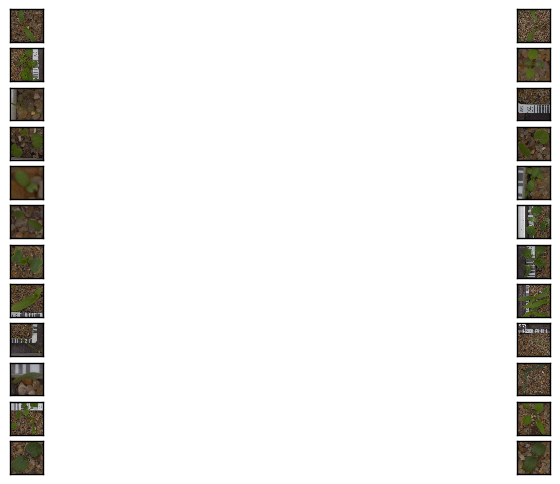

In [64]:
#from vgg16 import Vgg16
def plot_images_per_sub_directory(count):
    fig = mplot.figure(figsize=(12,6))
    i=0
    for directory in os.listdir(TRAIN_PATH):
        out = os.walk(os.path.join(TRAIN_PATH,directory))
        images = list(out)[0][2]
        for image in images[:count]:
            fig.add_subplot(len(os.listdir(TRAIN_PATH)),count,i+1)
            i+=1
            mplot.imshow(mpimg.imread(os.path.join(os.path.join(TRAIN_PATH,directory),image)))
            mplot.xticks([])
            mplot.yticks([])
            
plot_images_per_sub_directory(2)